# DDSP synthesizer

Evaluate the generation quality of the DDSP synthesizer using the GMM from T3.2 and predefined pitch and loudness profiles.

####  Expected outcome of T3: 
A fully generative model based on DDSP which can generate musical sounds without any input audio signal

In [4]:
# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds 
import ddsp
import utils
import os
import gin
import pickle
import matplotlib
import IPython.display as ipd
import numpy as np
import soundfile as sf 
import matplotlib.pyplot as plt
import scipy as sp
import librosa
import librosa.display
 
%matplotlib inline
sample_rate = 16000

## Predefine pitch and loudness profiles

Refer to the notebook [showing_models_local](./showing_models_local.ipynb)

In [5]:
# audio path
audio_path = 'Datasets/Piano/Audio/Piano_01.wav'

# model folder direction 
model_dir_z = 'Pretrained_Models_for_T2/piano_ae'

# dataset_statistics.pkl in .model folder
dataset_stats_file_z = os.path.join(model_dir_z, 'dataset_statistics.pkl')

# operative_config-0.gin in model folder
gin_file_z = os.path.join(model_dir_z, 'operative_config-0.gin')

Datasets/Piano/Audio/Piano_01.wav
shape of original signal: (960000,) 
 original sample rate: 16000
audio shape: (960000,)


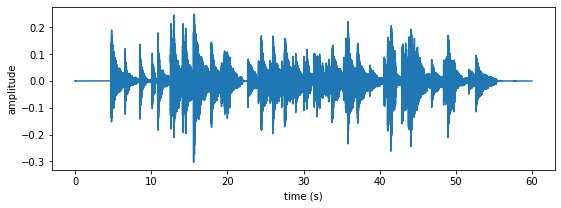

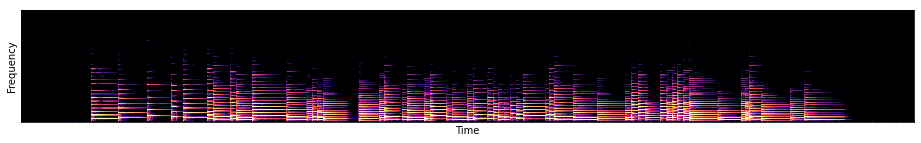

In [6]:
print(audio_path)
x_all, sr = sf.read(audio_path) #data,samplerate
print('shape of original signal:',np.shape(x_all),'\n','original sample rate:',sr)
sig = x_all[:] # choose the first channel of the original audio
 
# resample (down sampling to 16kHz) and take the 10-20 seconds
sig_re = librosa.resample(sig,sr,sample_rate)
audio = sig_re#[10*sample_rate:30*sample_rate]
print('audio shape:',np.shape(audio))
audio = audio[np.newaxis,:]

# plot wave form
T_all = audio.shape[1]
time = np.arange(T_all)/sample_rate
plt.figure(figsize=(9,3))
plt.plot(time, audio[0])
plt.xlabel('time (s)')
plt.ylabel('amplitude')

# Calculate Spectrogram and plot
utils.specplot(audio)

In [7]:
# play audio
ipd.Audio(audio[0], rate = sample_rate)

Text(0, 0.5, 'Loudness')

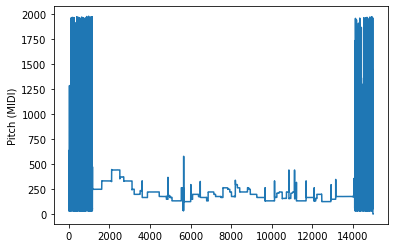

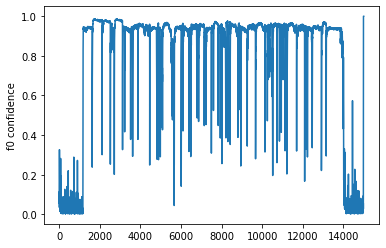

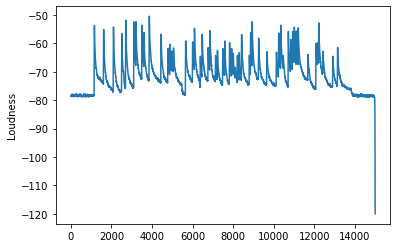

In [8]:
#extracting f0 with CREPE
ddsp.spectral_ops.reset_crepe()
f0_crepe, f0_confidence = ddsp.spectral_ops.compute_f0(audio[0], 
                                                       sample_rate= sample_rate,
                                                       frame_rate=250,
                                                       viterbi=False)
#extracting loudness 
loudness =ddsp.spectral_ops.compute_loudness(audio[0],
                     sample_rate= sample_rate,
                     frame_rate=250,
                     n_fft=2048,
                     ref_db=20.7,
                     use_tf=False)


# Plot Pitch/f0.
plt.figure(figsize=(6, 4))
f0_crepe_midi = ddsp.core.hz_to_midi(f0_crepe)
plt.plot(np.ravel(f0_crepe), label='crepe')
plt.ylabel('Pitch (MIDI)')
# Plot f0_confidence.
plt.figure(figsize=(6, 4))
plt.plot(np.ravel(f0_confidence), label='f0 confidence')
plt.ylabel('f0 confidence')
# Plot Loundness.
plt.figure(figsize=(6, 4))
plt.plot(np.ravel(loudness), label='loudness')
plt.ylabel('Loudness')

## Synthesize pitch, loudness and z features